In [1]:
#Manejo de matrices y tablas
import numpy as np
import pandas as pd

#Estadistica y funciones matemáticas
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles


#Probabilistic programs
import pymc3 as pm
import theano.tensor as tt #NOTA: theano va a cambiar a tensorflow en PyMC4
from theano.compile.ops import as_op
print('Running on PyMC3 v{}'.format(pm.__version__))

#Graficas
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC3 v3.9.3


# Métodos computacionales para obtener la posterior
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

En esta sesión veremos programación probabílistica.

Programación probabílistica se refiere a algoritmos que permiten hacer inferencia con distribuciones (no son programas inciertos).

Con probabilistic programming se puede samplear posteriors elaboradas

<center><img src="img/4_CB/model_mem.svg" width = "800" height = '800'></center>


|Stan|PyMC|Edward|
|:-:|:-:|:-:|
|<img src="img/4_CB/stan_logo.png" width = "150" height = '150'>|<img src="img/4_CB/PyMC3_banner.png" width = "150" height = '150'>|<img src="img/4_CB/edward_logo.png" width = "200" height = '200'>|

<center><img src="img/4_CB/PyMC3_banner.png" width = "150" height = '150'></center>
Nota: PyMC3 ... PyMC4 está en pre-release.

Basado en: Davidson-Pilon, C. (2015). Bayesian methods for hackers: probabilistic programming and Bayesian inference. https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

## Pero primero un corto tutorial de dot

Se pueden hacer modelos gráficos con Python usando la sintaxis de dot

In [2]:
#Primero definamos la gráfica
dot_text = 'digraph G {\
                     node[margin=0.2, shape=rectangle,\
                          style = rounded,\
                          width=0.8, height = .7];\
                     compound=true;\
                     newrank=true;\
                     d -> e [label=" mi texto "];\
                     subgraph cluster0{\
                        label = " ";\
                        label = "$theta_i$";\
                        labeljust = "l";  color = "red";\
                        f;\
                        g;\
                     };\
                     e -> f [lhead = cluster0, label="  "];\
                     f -> g;\
                     g -> h [ltail = cluster0];\
                     { rank=same; f; e};\
                     d [label = "Nodo", fixedsize=true, width=0.5,\
                                 shape = circle];\
                     e [label = "$mu$", shape = square,\
                                  width = 0.6 ];\
                     f [label = "VI", shape = plaintext];\
                     g [label = "$sum_i x_i$"];\
                     h [label = "$int beta_i di$",\
                                  shape = circle, peripheries = 4];\
                     }' 
#Tip: use single quote at start and end; double quotes for labels

In [3]:
#Ahora salvarla
s = Source(dot_text, filename="img/4_CB/tutorial_dot.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 
#  \usepackage{bigints}

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}






'img/4_CB/tutorial_dot.gv.svg'

Analicemos mensajes de texto de una persona (Fuente: Davidson-Pilon, 2015)

In [4]:
count_data = np.loadtxt("data/4_CB/txtdata.csv")
n_count_data = len(count_data)
dias = np.linspace(1, n_count_data, num = n_count_data, dtype = int)

<center><img src="img/4_CB/mstxt.svg" width = "1000" height = '1000'></center>

¿Cómo modelamos el conteo de mensajes por día? 

$$Conteo_{\text{día}} \sim Poisson(\lambda)$$

Nota: El parámetro $\lambda$ es el promedio y varianza al mismo tiempo.

<center><img src="img/4_CB/poisson.svg" width = "450" height = '450'></center>

Pero ... se ven diferentes

|<img src="img/4_CB/poisson.svg" width = "250" height = '250'>|<img src="img/4_CB/mstxt.svg" width = "400" height = '400'>|
|:-:|:-:|
|||

Un histograma es una guía visual (depende de los bins)

Pueden ser dos Poisson diferentes, después de un día $\tau$

Esta es la propuesta:
$$\lambda = 
\begin{cases} \lambda_a  & \text{día} \lt \tau \\
\lambda_b & \text{día} \ge \tau
\end{cases}
$$


Esta es la propuesta bayesiana completa:

<center><img src="img/4_CB/model_msj.svg" width = "700" height = '700'></center>


¿Por qué esas formas y distribuciones para los parámetros?

Parte ciencia (e.g. conjugate prior) y arte (conocimiento del área). Por ejemplo, para los $\lambda_a$ y $\lambda_b$ escogimos una exponencial con rate $\alpha = \frac{1}{\mathbb{E}[Conteo_{d}]}$. No es conjugate, pero hace algo deseable: castiga conteos altos. 

<center><img src="img/4_CB/exp.svg" width = "500" height = '500'></center>

Ahora tomemos muestra del modelo con PyMC

<center><img src="img/4_CB/model_msj.svg" width = "500" height = '500'></center>

PyMC guarda el modelo en la clase `Model`. Veamos el código.

In [5]:
# Primero definamos constantes y variables deterministicas
alpha = 1.0/count_data.mean()  # count_data holds our text counts.

# PyMC utiliza la clase `Model` para guardar el modelo
with pm.Model() as modelo_mensajes:
    
    ### Latentes
    lambda_antes = pm.Exponential("lambda_antes", lam = alpha) 
    lambda_despues = pm.Exponential("lambda_despues", lam = alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    #Siguiente línea: 
    #if primer argumento true, then tercero, else segundo
    lambda_usado = pm.math.switch(tau < dias, 
                                  lambda_despues, lambda_antes) 
    
    ### Likelihood    
    conteos = pm.Poisson("conteos", lambda_usado, 
                         observed=count_data)


In [6]:
#La variable model tiene toda la información 
#RV: random variables
print(modelo_mensajes.basic_RVs) #Todas 
print(modelo_mensajes.free_RVs) #Latentes / no observables
print(modelo_mensajes.observed_RVs) #Observables

#En prob. program. las variables son aleatorias (ejemplo)
rvs = modelo_mensajes.lambda_antes.random
print(np.round(rvs(),2), np.round(rvs(),2), np.round(rvs(),2))
modelo_mensajes.lambda_antes

[lambda_antes_log__, lambda_despues_log__, tau, conteos]
[lambda_antes_log__, lambda_despues_log__, tau]
[conteos]
11.43 7.44 25.75


lambda_antes

¡Ahora sí a tomar muestras de nuestro modelo!

In [7]:
with modelo_mensajes:
    trace = pm.sample(10000, chains = 4, cores = 2)
    #posterior_predictive = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_despues, lambda_antes]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
data = az.from_pymc3(
    trace=trace[8500:10000], #1500 samples to keep the image file light
    model=modelo_mensajes,
)
az.plot_trace(data, figsize = [10,7]);
plt.savefig("img/4_CB/trace_msjtxt.svg")
plt.close()

El modelo convergio. Hay tests, pero visualmente combina bien (plots derechos)

<center><img src="img/4_CB/trace_msjtxt.svg" width = "750" height = '750'></center>

Aún cuando escogimos prior exponenciales (lambda) y uniformes (tau), las posterior se ven diferentes. La data modificó nuestra creencia.

In [9]:
fig, ax = plt.subplots(1,2, figsize = [8,5])
dia = int(trace['tau'].mean())
az.plot_density(
    [trace['lambda_antes'], trace['lambda_despues']],
    data_labels=["Antes del " + str(dia) + " dia (media)", 
                 "Después"],
    shade=.1, ax = ax[0], hdi_prob=.999, 
)
az.plot_density(
    [trace['tau']], hdi_prob=.999,
    data_labels=["$\\tau$ (día) "], outline=True,
    shade=.25, ax = ax[1], colors = 'purple', 
)
ax[0].set_title('$\lambda$ (msj x día)', fontsize = 20)
ax[1].set_title('$\\tau$ (día de cambio)', fontsize = 20)
ax[0].set_xlabel('msj x día', fontsize = 15)
ax[1].set_xlabel('día de cambio', fontsize = 15)
ax[0].legend(loc='upper right')
fig.savefig('img/4_CB/Vis_msj_txt_post.svg')
plt.close()

<center><img src="img/4_CB/Vis_msj_txt_post.svg" width = "750" height = '750'></center>

Podemos sacar promedios y calcular intervalos de densidad con las muestras producidas por el algoritmo. El objeto que llamamos trace tiene la info por parámetro.

In [10]:
promedio_conteo = np.zeros_like(count_data, dtype='float')
#High density interval
HDI95_conteo = np.zeros_like(count_data, dtype='float') 
HDI5_conteo = np.zeros_like(count_data, dtype='float')
for i, dia in enumerate(dias):
    #las muestras están ordenadas como el algoritmo las tomó
    idx = dia < trace['tau'] 
    antes = trace['lambda_antes'][idx] 
    despues = trace['lambda_despues'][~idx]
    HDI95_conteo[i] = np.percentile(
        np.concatenate((antes,despues)),97.5
    )
    HDI5_conteo[i] = np.percentile(
        np.concatenate((antes,despues)),2.5
    )
    promedio_conteo[i] = np.concatenate((antes,despues)).mean()


In [14]:
plt.figure(figsize=(5, 5)); 
plt.plot(dias, count_data, '.',  label = 'Data')
plt.ylabel("Conteo mensajes", fontsize=16); 
plt.xlabel("Día", fontsize=16)
plt.title("Visualización Modelo", fontsize=20)   
hdi = az.hdi(trace['tau']) #high density interval (calculado con Arviz; igual a np.percentile)
plt.vlines(trace['tau'].mean(), count_data.min(), count_data.max(), color='C1')
plt.fill_betweenx(y=[count_data.min(), count_data.max()],
                  x1=hdi[0], x2=hdi[1], alpha=0.35, color='C1',
                 label = 'Día de aumento de mensajes ($\\tau$)');
plt.fill_between(x=np.linspace(1, len(dias), HDI5_conteo.size), 
                 y1=HDI5_conteo, y2=HDI95_conteo, alpha=0.25, color='k',
                 label = 'Promedio mensajes ($\lambda$)');
plt.plot(dias, promedio_conteo,  'k', lw=2); 
plt.legend(loc = 'upper left');
plt.savefig('img/4_CB/Vis_msj_txt.svg')
plt.close()

Hay un salto en msjs x día. ¿Qué pudo pasarle a esta persona en el salto? Especular; o si hay conocimiento del área podríamos lanzar una hipótesis.
<center><img src="img/4_CB/Vis_msj_txt.svg" width = "501" height = '500'></center>

Podemos testear directamente hipótesis. Por ejemplo, ¿qué tan seguros estamos que la tasa de mensajes antes y después del día de cambio es diferente?

100% seguros que msj x día (lambdas) difieren en el día del cambio


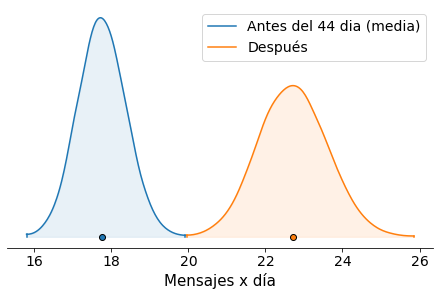

In [15]:
test = trace['lambda_antes']<trace['lambda_despues']
tA = str(int(test.mean()*100))
tB = "% seguros que msj x día (lambdas) difieren en el día del cambio"
print(tA + tB)
dia = int(trace['tau'].mean())
az.plot_density(
    [trace['lambda_antes'], trace['lambda_despues']],
    data_labels=["Antes del " + str(dia) + " dia (media)", 
                 "Después"],
    shade=.1, hdi_prob = .999, 
);
plt.xlabel('Mensajes x día', fontsize = 15)
plt.title("");

# Ejercicios (mensajes de texto Poisson)
1\.  Calcule el promedio de `lambda_antes` y `lambda_despues`.

In [ ]:
#Escriba su código aqui

2\.  Calcule el incremento porcentual promedio de mensajes por día. `pista:` Consiga la distribución de la variable *incremento porcentual*. No haga `lambda_antes.mean()/lambda_despues.mean()`. Es parecido, pero use todas las posteriores. Queremos el promedio de la distribución de *incremento porcentual*.

In [ ]:
#Escriba su código aqui

3\. Calcule el promedio de $\lambda_{antes}$ *dado* que $\tau < 45$. Recuerde: las muestras del sampleador están coordinadas. Es decir, busque los indices de $\tau$ menores a 45 y use ese indice para seleccionar muestras de $\lambda_{antes}$.

In [ ]:
#Escriba su código aqui

4\. Haga el siguiente modelo gráfico con la sintaxis `dot`
<center><img src="img/4_CB/Taller_pregunta_dot.png" width = "200" height = '200'></center>

In [ ]:
#Escriba su código aqui

# PyMC: Detalles

En PyMC el modelo "vive" en el objeto pm.Models 

In [16]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, 
                               testval=0.5) #testval valores iniciales
    data_generator = pm.Poisson("data_generator", parameter)

Python trata de emular lenguaje natural. El bloque `with` trabaja con el objeto pm.Model, con el alias model, y ejecuta lo que va dentro del bloque. 

Podemos trabajar con el alias 

In [17]:
with model:
    data_plus_one = data_generator + 1
print(data_plus_one.tag.test_value) #test values: valores iniciales
print(model.basic_RVs) 
rvs = model.poisson_param.random
print(np.round(rvs(),2), np.round(rvs(),2), np.round(rvs(),2))

1
[poisson_param_log__, data_generator]
4.69 1.08 1.35


PyMC3 tiene dos tipos de variables: estocásticas y determinísticas.

*  *Estocásticas*:  Variable aleatoria. Ejemplos en esta clase: `Poisson`, `DiscreteUniform`, and `Normal`.

*  *Determinísticas*: El nombre lo dice todo. Ejemplos en esta clase: formula cuadratica. Una vez conozco el input x, con seguridad sé el valor.  


## Estocásticas
Ya hemos usado variables estocásticas. Por ejemplo,

`mi_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`

El nombre para Python es *mi_variable*. El nombre para el sampleador es *discrete_uni_var*. Pueden ser diferentes o iguales. Recomendación: iguales. 

El 0 (límite bajo) y el 4 (alto) son los parámetros libres de la uniforme. Diferentes distribuciones y parámetros en (http://pymc-devs.github.io/pymc3/api.html)

Si hay N variables con distribuciones similares, se puede usar el parámetro `shape`

`betas_regresion = pm.Uniform("betas", 0, 1, shape = N)`

## Determinísticas

Hay dos formas de introducir variables determinísticas en nuestro modelo. Ya vimos una: con funciones del paquete PyMC. 

In [18]:
n_data_points = 5  
dias_o_cualquier_referencia = np.arange(n_data_points)
with pm.Model() as model:
    #Estocásticas
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)
    
    #Determinísticas
    lambda_ = pm.math.switch(tau >= dias_o_cualquier_referencia, 
                             lambda_1, lambda_2)  

`lambda_` es determinística. Usamos la función .switch con dos de las variables estocásticas (VE). En cada iteración, VE se "materializa" y .switch se aplica

Otra forma es con `pm.Deterministic`. 

In [19]:
def restar(x, y):
    return x - y

with pm.Model() as model_det:
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)

    det_1 = pm.Deterministic("Delta", restar(stochastic_1, stochastic_2))


La función restar debe poder trabajar con escalares o vectores.

Para una variable determinística, es recomendado primero tratar de usar funciones de PyMC o el backend (PyMC3, Theano; PyMC4, TensorFlow).

|<center><img src="img/4_CB/Theano_logo.svg" width = "300" height = '300'></center>|<center><img src="img/4_CB/Tensorflow-logo.svg" width = "300" height = '300'></center>|
|-|-|
|||

Veamos detalles del backend.


Pueden pensar en el backend como el caballo de trabajo. Hace los calculos y manipulaciones de la información. 

Se basa en objetos matemáticos llamados tensores (generalización de vectores y matrices)


Acá usamos la operación `stack`. Agrupa `p1` y `p2` en una nueva variable `p`. 

Se puede pensar como una lista con dos elementos (o una matriz con dos columnas). Los elementos NO son escalares.

La nueva variable `p` la podemos pasar a una variable estocástica como probabilidad de dos categorias.

In [20]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2]) 
    
    assignment = pm.Categorical("assignment", p)

Vamos a usar muchas operaciones del backend en el curso. 

## Data/Observaciones

Hemos definido priors ...

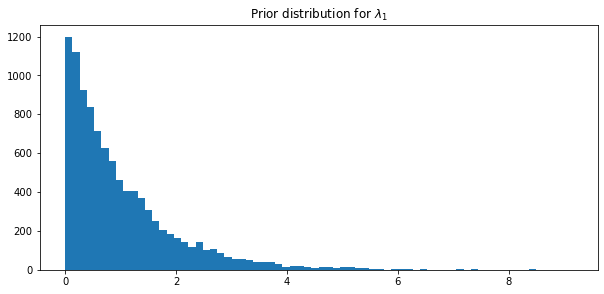

In [21]:
fig = plt.figure(figsize = (10, 4.5))
samples = lambda_1.random(size=10000)
plt.hist(samples, bins=70); 
plt.title("Prior distribution for $\lambda_1$");

 ... ahora veamos likelihoods y data

Es sencillo. Todas las variables estocásticas tienen un parámetro `observed`. A la que le asignemos la data es el likelihood.

In [22]:
# Generemos una data
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)
print(model.free_RVs) #Latentes / no observables
print(model.observed_RVs) #Observables

[10 25 15 20 35]
[lambda_1_log__, lambda_2_log__, tau]
[obs]


# Modelos bayesianos de `análisis` de datos

## A/B Testing

Tal vez el diseño experimental más simple y popular. Se busca cuál es mejor opción, A o B. 

Por ejemplo, ¿qué robot debería atender en un aeropuerto?

|<img src="img/4_CB/Robot_A.webp" width = "300" height = '300'>|<img src="img/4_CB/Robot_B.jpg" width = "250" height = '250'>|
|:-:|:-:|
|||

Diseño experimental: dos grupos en distintos aeropuertos. El tamaño de cada grupo es $n_1$ y $n_2$ con $k_1$ y $k_2$ conteos prefiriendo robot 1. Cada aeropuerto tiene una proporción latente $\theta_1$ y $\theta_2$.

Formulación bayesiana:
<center><img src="img/4_CB/model_ab.svg" width = "600" height = '600'></center>

In [23]:
#No conocemos estas cantidades. Son los theta del modelo gráfico.
true_p_A = 0.05 
true_p_B = 0.04

#Tenemos más datos en un sitio (A). No es problema
N_A = 1500
N_B = 750

#Generemos datos. Son los k del modelo gráfico.
datos_A = st.bernoulli.rvs(true_p_A, size=N_A)
datos_B = st.bernoulli.rvs(true_p_B, size=N_B)
print("Obs del sitio A: ", datos_A[:30], "...")
print("Obs del sitio B: ", datos_B[:30], "...")
print("Promedio A: ", np.mean(datos_A))
print("Promedio B: ", np.mean(datos_B))

Obs del sitio A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] ...
Obs del sitio B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] ...
Promedio A:  0.052
Promedio B:  0.037333333333333336


In [24]:
# Formulemos el modelo pymc3 con priors uniformes para p_A & p_B
with pm.Model() as model:
    
    #Priors
    p_A = pm.Beta("p_A", 1, 1) #Beta(1,1) es uniforme en el rango 0,1
    p_B = pm.Beta("p_B", 1, 1)
    
    #Variable de interés: la diferencia de proporciones.
    delta = pm.Deterministic("delta", p_A - p_B)

    # Likelihood. Asumimos independencia de los dos sitios.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=datos_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=datos_B)

    # Llamemos el algoritmo para samplear.
    step = pm.Metropolis() #Tipo de algoritmo.
    nsamples = 20000
    trace = pm.sample(nsamples, step=step)
    burned_trace=trace[1000:] #burn-in; importante para Metropolis

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
#Ahora grafiquemos
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
data = az.from_pymc3(trace=burned_trace, model=model)

#Convergencia
az.plot_trace(data, figsize = [10,7]);
plt.savefig("img/4_CB/trace_proporcion.svg"); plt.close()

#Densidades 
az.plot_density(
    [p_A_samples,p_B_samples,delta_samples],
    data_labels = ['Proporción A', 'Proporción B', 'Diferencia'],
    shade=.2, colors = ['green','red','blue'] ,hdi_prob=.95, 
)
plt.vlines(true_p_A, 0, 80, linestyle="--", 
           label="Verdadero $p_A$ (desconocido)", color ='green')
plt.vlines(true_p_B, 0, 80, linestyle="--", 
           label="Verdadero $p_B$ (desconocido)", color ='red')
plt.vlines(true_p_A-true_p_B, 0, 80, linestyle="--", 
           label="Verdadero $\delta$ (desconocido)", color ='blue')
plt.legend()
plt.title('')
plt.savefig("img/4_CB/density_proporcion.svg"); plt.close()

Convergencia
<center><img src="img/4_CB/trace_proporcion.svg" width = "600" height = '600'></center>

Densidades (todas las cadenas)
<center><img src="img/4_CB/density_proporcion.svg" width = "450" height = '450'></center>

¿Por qué es más "gorda" la distribución de B? ¿Por qué tenemos menos certeza? ¿Qué tiene que ver los datos?

In [26]:
# El área bajo la curva <0 es la probabilidad
# que el sitio A tenga una menor proporción que
# el sitio B.
print("Probabilidad proporcion A menor a B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probabilidad proporcion A mayor a B: %.3f" % \
    np.mean(delta_samples > 0))

Probabilidad proporcion A menor a B: 0.064
Probabilidad proporcion A mayor a B: 0.936


¿Son esas probabilidades suficientes para decidir? Debatir

Acabamos de comparar dos proporciones con técnicas bayesianas.

El tamaño muestral se incluye automaticamente en el análisis: menor certeza para $p_B$.

Podemos hacer las preguntas que queramos de las muestras e.g. moda, areas bajo la curva, etc.

## Otro ejemplo binario: mentiras

Situación: un investigador le interesa la tasa de trampa en una universidad

Solución 1: 
* preguntar a los estudiantes un si o un no (método directo)
    * problema: privacidad, desconfianza en promesa de no castigo.


Solución 2: 
* lanzar moneda en privado. 
    * Si cae cara, escriba la verdad. 
    * Si cae sello vuelva lanzar. Escriba:
        * "sí hago trampa" si cae cara, 
        * "no hago trampa" si cae sello.

Es privado. El experimentador no sabe la fuente de las respuestas. Pueden ser la verdad o el resultado del segundo lanzamiento.


¿Qué distribución podemos usar para data binaria? Binomial

$$P( X = k| p, N) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

k: éxitos <br>
N: intentos <br>
p: probabilidad éxito

En lenguaje natural: <br>
Si conozco la probabilidad del evento (cara) y el número de intentos (veces que se lanza la moneda), sé la probabilidad de número de éxitos.

¡A modelar!

<center><img src="img/4_CB/model_trampa.svg" width = "750" height = '750'></center>


In [4]:
prob_cara = 0.5
prob_sello = 0.5
with pm.Model() as model:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic(
        "prop_tramposos", 
        prob_cara*prob_trampa + prob_sello*prob_cara
    )

Ahora, definamos un likelihood binomial para la data.

In [5]:
# Data
N = 100 #Número de estudiantes
trampo = 35 #Número de reportes que dicen hacer trampa
with model:
    tramposos = pm.Binomial("obs", N, prop_trampo, 
                            observed=trampo)

# Ya podemos samplear
with model:
    step = pm.Metropolis(vars=[prob_trampa])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 53 seconds.
The number of effective samples is smaller than 25% for some parameters.


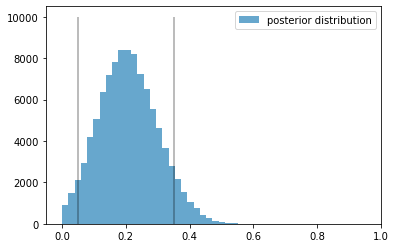

In [6]:
p_trace = burned_trace["prob_trampa"]
plt.hist(p_trace, histtype="stepfilled", alpha=0.75, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [10000, 10000], alpha=0.35)
plt.xlim(-0.05, 1)
plt.legend();

## PRO TIP

Podemos crear un modelo con muchas variables con un for loop. Hay que inicializar un array con tipo de dato `objeto`

In [7]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

## Otro ejemplo: desastre del challenger

<center><img src="img/4_CB/challenger.jpg" width = "450" height = '450'></center>

Potencial razón: 

Daño de un anillo en una conexión de uno de los impulsores de un cohete (i.e. se daño una pieza)

In [8]:
#Cargar data
#Filas: 23 vuelos previos. 
#Col 1: temperatura externa (fahrenheit); 
#Col 2: falla de anillo (0 no, 1 si)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/4_CB/challenger_data.csv", 
                                skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

In [9]:
#Visualizar data
fig = plt.figure(figsize = (6,6))
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("¿Daño en anillo? \n (0: no; 1: si)", fontsize = 18)
plt.xlabel("Temperatura Externa (Fahrenheit)", fontsize = 18)
plt.title("Defectos en anillos vs temperatura", fontsize = 22);
fig.savefig('img/4_CB/challenger1.svg')
plt.close()

¿Qué relación vemos entre temperatura ambiental y daño del anillo?

<center><img src="img/4_CB/challenger1.svg" width = "400" height = '400'></center>

Podemos modelar variables binarias con la función logística
$$ p(t) = \frac{1}{1+e^{\beta t + \alpha}}$$

<center><img src="img/4_CB/logistic.svg" width = "500" height = '500'></center>

Este es el modelo bayesiano

<center><img src="img/4_CB/model_challenger.svg" width = "600" height = '600'></center>

In [ ]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defecto (0 no, 1 si)

with pm.Model() as model:
    #Caveat computacional: beta y alpha empiezan en cero para evitar 
    # que p se vaya a las esquinas 0 o 1 desde el comienzo
    
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0) 
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 
                         1.0/(1. + tt.exp(beta*temperature + alpha)))   
    defecto = pm.Bernoulli("defecto", p, observed=D)
    
    # Sampleo
    start = pm.find_MAP() #Max. a posteriori con valores iniciales
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

In [ ]:
beta_samples = burned_trace["beta"]
alpha_samples = burned_trace["alpha"]
data = az.from_pymc3(trace=burned_trace, model=model)

#Convergencia
az.plot_trace(data, figsize = [10,7], var_names=('beta','alpha'));
plt.savefig("img/4_CB/trace_challenger.svg"); plt.close()

#Densidades
fig, ax = plt.subplots(1,2, figsize=(10,5))
az.plot_density(
    [beta_samples], ax = ax[0],
    shade=.2, colors = ['green'], hdi_prob=.95, 
)
az.plot_density(
    [alpha_samples], ax = ax[1],
    shade=.2, colors = ['red'] ,hdi_prob=.95, 
)
ax[0].set_title(r'$\beta$', fontsize = 25)
ax[1].set_title(r'$\alpha$', fontsize = 25)
fig.savefig("img/4_CB/density_challenger.svg"); plt.close()

El modelo combina relativamente bien

<center><img src="img/4_CB/trace_challenger.svg" width = "600" height = '600'></center>

Notable que $\beta$, la importancia de la temperatura, no incluya cero. La temperatura sí jugó un rol.

<center><img src="img/4_CB/density_challenger.svg" width = "700" height = '700'></center>

In [ ]:
Con las posterior podemos obtener valores de p

In [ ]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(temperature.min() - 5, 
                temperature.max()+5, 50)[:, None] #[:, None] lo vuelve 1D

p_t = logistic(t.T, beta_samples[:, None], 
               alpha_samples[:, None])
mean_prob_t = p_t.mean(axis=0)

In [ ]:
fig = plt.figure(figsize = (7,5))
plt.plot(t, mean_prob_t, lw=3, 
         label="Promedio posterior")
plt.plot(t, p_t[0, :], ls="--", 
         label="Ejemplo del posterior")
plt.plot(t, p_t[-2, :], ls="--", 
         label="Ejemplo del posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5, label = 'Data')
plt.title("Posterior de prob. de defecto", fontsize = 18)
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probabilidad", fontsize = 15)
plt.xlabel("Temperatura", fontsize = 15);
fig.savefig('img/4_CB/challenger_p.svg')
plt.close();

Posterior: promedio y algunos ejemplos. Generamos muchas versiones de la hipótesis logística.
<center><img src="img/4_CB/challenger_p.svg" width = "551" height = '550'></center>

Podemos incluso generar intervalos de certidumbre

In [ ]:
#95 HDI
qs = mquantiles(p_t, [0.025, 0.975], axis=0) 

In [ ]:
fig = plt.figure(figsize = (7,5))
plt.fill_between(t[:, 0], *qs, alpha=0.4,
                 color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% HDI", color="#7A68A6", alpha=0.4)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="Promedio posterior")
plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.scatter(temperature, D, color="k", s=50, alpha=0.5, label='Data')
plt.xlabel("Temperatura", fontsize = 15)
plt.ylabel("Probabilidad", fontsize = 15)
plt.title("Posterior de prob. de defecto", fontsize = 18);
plt.legend(loc="lower left")
fig.savefig('img/4_CB/challenger_p95.svg')
plt.close();

Podemos saber donde tenemos más incertidumbre: temperaturas entre 50 y 70. Enfocarnos en recoger datos en esa zonas.
<center><img src="img/4_CB/challenger_p95.svg" width = "551" height = '550'></center>

Podemos poner probabilidades para la temperatura que hizo el día del desastre: 31 Fahrenheit

In [ ]:
prob_31 = logistic(31, beta_samples, alpha_samples)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
az.plot_density(
    [prob_31], ax = ax,
    shade=.2, colors = ['purple'], hdi_prob=.95, 
)
ax.set_xlim(0.997, 1)
ax.set_title(r"Probabilidad de defecto en el anillo O, dado $t = 31$ Fahrenheit",
            fontsize = 18)
ax.set_xlabel("Probabilidad",fontsize = 15);
fig.savefig("img/4_CB/challenger_p_dia.svg")
plt.close()

<center><img src="img/4_CB/challenger_p_dia.svg" width = "400" height = '400'></center>

# En resumen ...

Usamos PyMC para tomar muestras.

La sintaxis básica es 

with pm.Model() as ELNOMBREQUEQUIERA: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; distribuciones y sampleador

### Ejercicios

1\. Ponga valores extremos para el ejemplo de trampas. ¿Qué pasa si observamos 25 respuestas afirmativas? ¿10?¿50?

2\. Gráfique $\alpha$ contra $\beta$ ¿Qué significa, cómo la interpreta?


In [10]:
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' --SlidesExporter.reveal_scroll=True 4_Comp_2.ipynb #Saves slide

[NbConvertApp] Converting notebook 4_Comp_2.ipynb to slides
[NbConvertApp] Writing 422088 bytes to 4_Comp_2.slides.html



Para salvar las diapositivas a PDF (en Chrome), correr nbconvert para que abra las diapositivas en un servidor local (la transition y el theme son opcionales):

!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='convex' nombre_de_mi_notebook.ipynb --post serve

Luego, a la dirección añadirle ?print-pdf después del .html:

http://127.0.0.1:8000/nombre_de_mi_notebook.slides.html?print-pdf

Y luego, imprimir y darle salvar como pdf

In [ ]:
#Para salvar a pdf
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' 4_Comp_2.ipynb --post serve


[NbConvertApp] Converting notebook 4_Comp_2.ipynb to slides
[NbConvertApp] Writing 422089 bytes to 4_Comp_2.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/4_Comp_2.slides.html
Use Control-C to stop this server


# Anexos

In [9]:
#Memoria
dot_text = 'digraph G {rankdir=LR; compound=true; newrank=true; labelloc="t";label="Caída Exponencial de la Memoria";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.7, lblstyle="font=\\small"];\
           alpha -> theta;\
           beta -> theta;\
           n -> k;\
           subgraph cluster0{margin = 10; labeljust=l; lblstyle="font=\\small";\
             label = " "; label = "$Tiempo para recordar_j$";\
             style = rounded;\
             t -> theta;\
             theta -> k ;\
             subgraph cluster1{labelloc = b\
                label = " "; label = "$Persona_i$"; labeljust=l;\
                k;\
              }\
           }\
           { rank=same; t; theta};\
           { rank=same; n; k};\
           /* nodes */\
           alpha[label="$alpha$", lblstyle="font=\\large"];\
           beta[label="$beta$", lblstyle="font=\\large"];\
           theta[peripheries=2, label="$Mem_j$"];\
           t[label="$t_j$", fillcolor=gray, style=filled];\
           k[shape=square, label="$Rec_{i,j}$", fillcolor=gray,style=filled];\
           n[shape=square, label="$Items_n$",fillcolor=gray,style=filled];\
           }' #warning: use single quote at start and end; double quotes for labels

s = Source(dot_text, filename="img/4_CB/model_mem.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{25pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 
#  \usepackage{bigints}

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}


'img/4_CB/model_mem.gv.svg'

In [15]:
#Msjs texto 
dot_text = 'digraph G {rankdir=LR; compound=true; newrank=true; labelloc="t";\
           label="Mensajes de Texto por Día";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.7, lblstyle="font=\\small"];\
           alpha -> lambda_a;\
           alpha -> lambda_b;\
           lambda_a -> lambda;\
           lambda_b -> lambda;\
           tau -> lambda;\
           subgraph cluster0{style = rounded; labeljust=l;\
             label = "$d Días$";\
             lambda -> dias;\
           }\
           /* nodes */\
           alpha [label = "$alpha$"];\
           lambda_a [label = "$lambda_a$"];\
           lambda_b [label = "$lambda_b$"];\
           lambda [label = "$lambda_{d}$", peripheries = 2];\
           tau [label = "$tau$", shape = square];\
           dias [label = "$Conteo_{d}$", width=1, shape = square, style = filled, fillcolor = gray];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_msj.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

'img/4_CB/model_msj.gv.svg'

In [ ]:
fig  = plt.figure(figsize = [12.5,5.5])
count_data = np.loadtxt("data/4_CB/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Tiempo (días)", fontsize = 15)
plt.ylabel("Mensajes de texto recibidos", fontsize = 15)
plt.title("¿Cambiaron los hábitos de texteo?", fontsize = 20)
plt.xlim(0, n_count_data);
fig.savefig("img/4_CB/mstxt.svg")
plt.close()

In [ ]:
# Visualización distribución Poisson
lambdda = 25
fig, ax = plt.subplots(1, 1)
x = np.arange(st.poisson.ppf(0.01, lambdda), st.poisson.ppf(0.99, lambdda))
ax.plot(x, st.poisson.pmf(x, lambdda), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, st.poisson.pmf(x, lambdda), colors='b', lw=5, alpha=0.5)
ax.set_xlabel('Conteo', fontsize = 15);
fig.savefig("img/4_CB/poisson.svg")
plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1)
count_data = np.loadtxt("data/4_CB/txtdata.csv")
rate =  1 / (1/count_data.mean())
x = np.linspace(st.expon.ppf(0.01, scale = rate), st.expon.ppf(0.99, scale = rate), 100)
ax.plot(x, st.expon.pdf(x, scale = rate),'r-', lw=5, alpha=0.6, 
        label='Exponential; rate = ' + str(round(rate,2)))
ax.set_xlabel('Parámetro Poisson', fontsize = 15);
ax.set_ylabel('PDF', fontsize = 15);
ax.legend()
fig.savefig("img/4_CB/exp.svg")

In [18]:
#A/B testing
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="A/B testing";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.5];\
           theta_1 -> k_1;\
           n_1 -> k_1;\
           theta_2 -> k_2;\
           n_2 -> k_2;\
           theta_1->delta;\
           theta_2->delta;\
           /* nodes */\
           delta [label = "$delta$", peripheries = 2];\
           theta_1 [label = "$theta_1$"];\
           theta_2 [label = "$theta_2$"];\
           k_1 [label = "$k_{1}$", shape = square, style = filled, fillcolor = gray];\
           k_2 [label = "$k_{2}$", shape = square, style = filled, fillcolor = gray];\
           n_1 [label = "$n_{1}$", shape = square, style = filled, fillcolor = gray];\
           n_2 [label = "$n_{2}$", shape = square, style = filled, fillcolor = gray];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_ab.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 


'img/4_CB/model_ab.gv.svg'

In [22]:
#Tramposos
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Tramposos";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.7];\
           p_trampa -> p_obt;\
           p_obt -> X;\
           N -> X;\
           p_trampa [label = "$Prob_{trampa}$"];\
           p_obt [label = "$Prop_{tramposos}$", peripheries = 2, width=0.9];\
           X [label = "$Tramposos$", shape = square, width=0.9,\
                 style = filled, fillcolor = gray];\
           N [fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_trampa.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 



'img/4_CB/model_trampa.gv.svg'

In [ ]:
#Gráfica logística
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");
plt.savefig('img/4_CB/logistic.svg');
plt.close();

In [25]:
#Challenger
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Challenger";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.6];\
           beta -> p;\
           alpha -> p;\
           temp->p;\
           p->obs;\
           /* nodes */\
           beta [label = "$beta$"];\
           alpha [label = "$alpha$"];\
           p [label = "$p$", peripheries = 2];\
           obs [label = "Defecto", shape = square, style = filled, fillcolor=gray];\
           temp [label = "Clima", style = filled, fillcolor=gray];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_challenger.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

#beta_dist [texlbl = "$\\beta \sim  Normal(\\mu=0, \\sigma^2=1000)$", shape = plaintext];\
#alpha_dist [texlbl = "$\\alpha \sim  Normal(\\mu=0, \\sigma^2=1000)$", shape = plaintext];\
#obs_dist [texlbl = "$Defecto \sim Bernoulli(p)$", shape = plaintext];\
#p_dist [texlbl = "$p = \\frac{1}{1+e^{\\beta \\text{Clima} + \\alpha}}$", shape = plaintext];\


'img/4_CB/model_challenger.gv.svg'

In [ ]:
#NO BORRAR. FORMA ALTERNATIVA DE HACER DIAGRAMAS. PROBLEMA: dot2tex NO SIEMPRE ME SIRVE
''' 
#Memoria
dot_text = 'digraph G {rankdir=LR; compound=true; newrank=true; labelloc="t";label="Caída Exponencial de la Memoria";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.4, lblstyle="font=\\small"];\
           k->placeholder[style = invis];\
           placeholder->alpha_dist[style = invis];\
           alpha_dist->beta_dist -> theta_dist -> k_dist[style = invis];\
           alpha -> theta;\
           beta -> theta;\
           n -> k;\
           subgraph cluster0{margin = 10; labeljust=l; lblstyle="font=\\small";\
             label = " "; texlbl = "$\;\;\;\;\;\;\;\;\;\;\\;\;\;\;\\;\;\;\;\
                                     \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;j$ Tiempo para recordar";\
             style = rounded;\
             t -> theta;\
             theta -> k ;\
             subgraph cluster1{labelloc = b\
                label = " "; texlbl = "$\;\;\;\;\;\;\;\;\;\;\;\; i$ Personas";\
                k;\
              }\
           }\
           { rank=same; t; theta};\
           { rank=same; n; k};\
           { rank=same; alpha_dist; beta_dist; theta_dist; k_dist};\
           /* nodes */\
           placeholder[style=invis, shape = square, width = 0.1, margin = 0, label =""];\
           alpha[texlbl="$\\alpha$", lblstyle="font=\\large"];\
           beta[texlbl="$\\beta$", lblstyle="font=\\large"];\
           theta[peripheries=2, texlbl="$Mem_j$"];\
           t[texlbl="$t_j$", fillcolor=gray, style=filled];\
           k[shape=square, texlbl="$Rec_{i,j}$", fillcolor=gray,style=filled];\
           n[shape=square, texlbl="$Items_n$",fillcolor=gray,style=filled];\
           alpha_dist[shape = plaintext, margin = 0, texlbl="$\\alpha \\sim Beta(1,1)$", lblstyle="font=\\small"];\
           beta_dist[shape = plaintext, margin = 0, texlbl="$\\beta \\sim Beta(1,1)$",lblstyle="font=\\small"];\
           theta_dist[shape = plaintext, margin = 0, texlbl="$Mem_j \\sim min\\left(1, e^{-\\alpha t_j} + \\beta\\right)$", lblstyle="font=\\small"];\
           k_dist[shape = plaintext, margin = 0, texlbl="$Rec_{i,j} \\sim Binomial(Mem_j,Items_n)$", lblstyle="font=\\small"];\
           }' #warning: use single quote at start and end; double quotes for labels


tex = d2t.dot2tex(dot_text, format='tikz', preproc = True) #makes sure it looks good in tex
tex = d2t.dot2tex(dot_text, texmode = 'verbatim', crop=True) #crop: the page size equal to the model
diagram_tex = open('img/4_CB/model_mem.tex', 'w')
diagram_tex.write(tex) 
diagram_tex.close()

# this builds a pdf-file inside a directory
pdf = build_pdf(tex)
pdf.save_to('img/4_CB/model_mem.pdf') #convertir a svg y pulir/editar posiciones en inkscape
'''